# Optimizing image generation prompting using CLIP scores
In this notebook we will compare different prompts and measure a text-to-image similarity metric: The [CLIP score](https://lightning.ai/docs/torchmetrics/stable/multimodal/clip_score.html).

Before running this notebook, load the following modules from the "Softwares" panel on the left.
```
GCCore/11.3.0
Python/3.10.4
```

This is how the metric is initialized

In [1]:
from torchmetrics.multimodal.clip_score import CLIPScore

metric = CLIPScore(model_name_or_path="/projects/p_scads_llm_secrets/models/clip-vit-base-patch16")

We start with this example image.

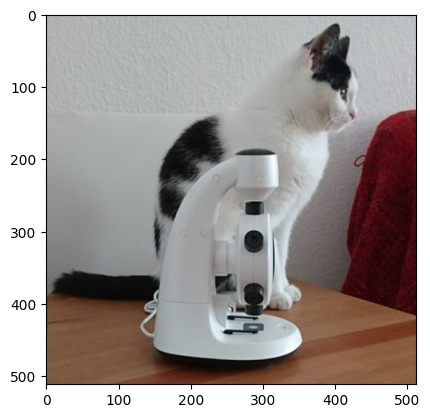

In [2]:
import seaborn as sns
from PIL import Image
from matplotlib import pyplot as plt

image = Image.open("real_cat.png")
plt.imshow(image)

In [3]:
from torchvision.transforms import functional as TF

score = metric(TF.to_tensor(image), "cat")
score.detach()

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


tensor(23.1938)

In [4]:
score = metric(TF.to_tensor(image), "microscope")
float(score.detach())

24.386198043823242

## Recap: Generating images
We will now use a prompt to generate an image and will measure if it shows a cat.

In [5]:
import torch
import numpy as np
from diffusers import DiffusionPipeline, AutoencoderTiny

pipe = DiffusionPipeline.from_pretrained("/projects/p_scads_llm_secrets/models/stable-diffusion-2-1-base", torch_dtype=torch.float16).to("cuda")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

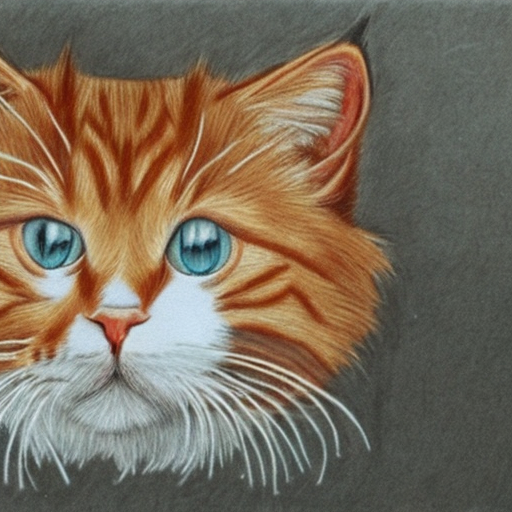

In [6]:
prompt = "Draw a realistic photo of a cat."

cat = pipe(prompt).images[0]
cat

In [7]:
score = metric(torch.as_tensor(np.array(cat)), "cat")
np.asarray(score.detach())

array(27.982786, dtype=float32)

## Benchmarking prompts
To compare different prompts quantitatively, we run image generation in a loop and measure their quality. As a control, we also generate images that show dogs and no cats.

Using this strategy, we can do prompt engineering / prompt optimization in an informed way.

In [8]:
num_attempts = 10
prompts = ["Draw a realistic photo of a cat.", 
           "Draw a cat",
           "cat", 
           "Draw a realistic photo of a dog."]

data = {"prompt":[],
        "score":[]}
for prompt in prompts:
    for i in range(num_attempts):
        image = pipe(prompt).images[0]

        score = metric(TF.to_tensor(np.array(image)), "cat")
        data["score"].append(float(score.detach()))
        data["prompt"].append(prompt)

        print(f"{prompt}: {score}")

  0%|          | 0/50 [00:00<?, ?it/s]

Draw a realistic photo of a cat.: 23.255903244018555


  0%|          | 0/50 [00:00<?, ?it/s]

Draw a realistic photo of a cat.: 22.690141677856445


  0%|          | 0/50 [00:00<?, ?it/s]

Draw a realistic photo of a cat.: 22.825510025024414


  0%|          | 0/50 [00:00<?, ?it/s]

Draw a realistic photo of a cat.: 23.143962860107422


  0%|          | 0/50 [00:00<?, ?it/s]

Draw a realistic photo of a cat.: 23.16631317138672


  0%|          | 0/50 [00:00<?, ?it/s]

Draw a realistic photo of a cat.: 23.195358276367188


  0%|          | 0/50 [00:00<?, ?it/s]

Draw a realistic photo of a cat.: 22.822132110595703


  0%|          | 0/50 [00:00<?, ?it/s]

Draw a realistic photo of a cat.: 22.5621395111084


  0%|          | 0/50 [00:00<?, ?it/s]

Draw a realistic photo of a cat.: 23.087892532348633


  0%|          | 0/50 [00:00<?, ?it/s]

Draw a realistic photo of a cat.: 23.033252716064453


  0%|          | 0/50 [00:00<?, ?it/s]

Draw a cat: 23.2518310546875


  0%|          | 0/50 [00:00<?, ?it/s]

Draw a cat: 23.055654525756836


  0%|          | 0/50 [00:00<?, ?it/s]

Draw a cat: 23.003101348876953


  0%|          | 0/50 [00:00<?, ?it/s]

Draw a cat: 22.887287139892578


  0%|          | 0/50 [00:00<?, ?it/s]

Draw a cat: 22.686935424804688


  0%|          | 0/50 [00:00<?, ?it/s]

Draw a cat: 22.910503387451172


  0%|          | 0/50 [00:00<?, ?it/s]

Draw a cat: 23.122501373291016


  0%|          | 0/50 [00:00<?, ?it/s]

Draw a cat: 23.050384521484375


  0%|          | 0/50 [00:00<?, ?it/s]

Draw a cat: 23.42228126525879


  0%|          | 0/50 [00:00<?, ?it/s]

Draw a cat: 23.225465774536133


  0%|          | 0/50 [00:00<?, ?it/s]

cat: 22.40766143798828


  0%|          | 0/50 [00:00<?, ?it/s]

cat: 22.762962341308594


  0%|          | 0/50 [00:00<?, ?it/s]

cat: 23.376678466796875


  0%|          | 0/50 [00:00<?, ?it/s]

cat: 23.223068237304688


  0%|          | 0/50 [00:00<?, ?it/s]

cat: 22.962879180908203


  0%|          | 0/50 [00:00<?, ?it/s]

cat: 23.763778686523438


  0%|          | 0/50 [00:00<?, ?it/s]

cat: 22.8660888671875


  0%|          | 0/50 [00:00<?, ?it/s]

cat: 23.103445053100586


  0%|          | 0/50 [00:00<?, ?it/s]

cat: 23.14302635192871


  0%|          | 0/50 [00:00<?, ?it/s]

cat: 23.255332946777344


  0%|          | 0/50 [00:00<?, ?it/s]

Draw a realistic photo of a dog.: 22.975496292114258


  0%|          | 0/50 [00:00<?, ?it/s]

Draw a realistic photo of a dog.: 22.700176239013672


  0%|          | 0/50 [00:00<?, ?it/s]

Draw a realistic photo of a dog.: 22.992448806762695


  0%|          | 0/50 [00:00<?, ?it/s]

Draw a realistic photo of a dog.: 22.28465461730957


  0%|          | 0/50 [00:00<?, ?it/s]

Draw a realistic photo of a dog.: 22.415054321289062


  0%|          | 0/50 [00:00<?, ?it/s]

Draw a realistic photo of a dog.: 22.94266700744629


  0%|          | 0/50 [00:00<?, ?it/s]

Draw a realistic photo of a dog.: 23.022546768188477


  0%|          | 0/50 [00:00<?, ?it/s]

Draw a realistic photo of a dog.: 23.034626007080078


  0%|          | 0/50 [00:00<?, ?it/s]

Draw a realistic photo of a dog.: 23.090618133544922


  0%|          | 0/50 [00:00<?, ?it/s]

Draw a realistic photo of a dog.: 22.82175064086914


In [9]:
import pandas as pd

data = pd.DataFrame(data)
data

,prompt,score
0,Draw a realistic photo of a cat.,23.255903
1,Draw a realistic photo of a cat.,22.690142
2,Draw a realistic photo of a cat.,22.825510
3,Draw a realistic photo of a cat.,23.143963
4,Draw a realistic photo of a cat.,23.166313
5,Draw a realistic photo of a cat.,23.195358
6,Draw a realistic photo of a cat.,22.822132
7,Draw a realistic photo of a cat.,22.562140
8,Draw a realistic photo of a cat.,23.087893
9,Draw a realistic photo of a cat.,23.033253


<Axes: >

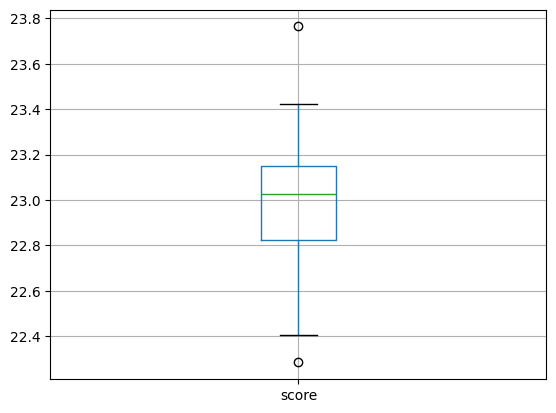

In [11]:
# data.boxplot()

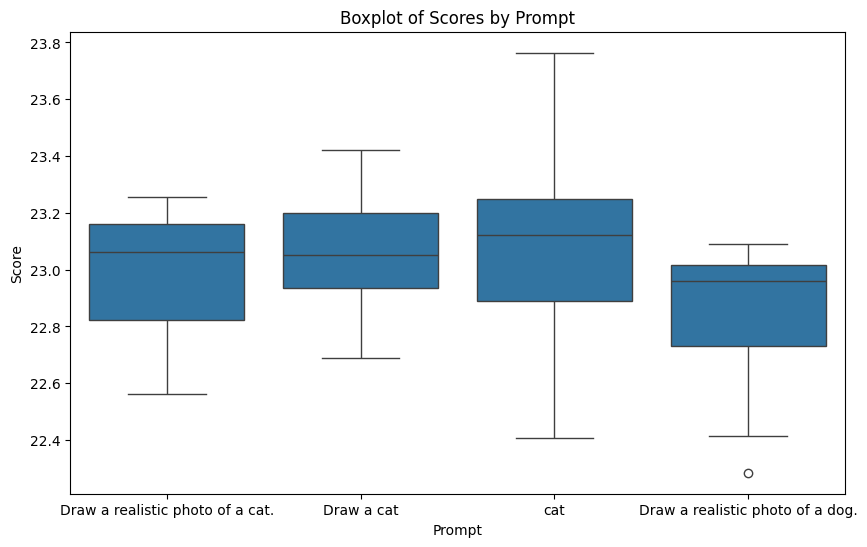

In [10]:
# Plotting the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='prompt', y='score', data=data)
plt.title('Boxplot of Scores by Prompt')
plt.xlabel('Prompt')
plt.ylabel('Score')
plt.show()

## Exercise
Append more prompts to the list above. Attempt to improve the score for the image showing a cat.

Measure which of the prompts produces the most photorealistic images. 